In [1]:
# example, some code based on https://github.com/shihenw/convolutional-pose-machines-release

In [2]:
from __future__ import print_function
from __future__ import division

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pickle

import skimage.io
import skimage.transform
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
import cv2

import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import cpm

In [3]:
def detect_objects_heatmap(heatmap):
  data = 256 * heatmap 
  data_max = filters.maximum_filter(data, 3, mode='reflect')
  maxima = (data == data_max)
  data_min = filters.minimum_filter(data, 3, mode='reflect')
  diff = ((data_max - data_min) > 0.3)
  maxima[diff == 0] = 0
  labeled, num_objects = ndimage.label(maxima)
  slices = ndimage.find_objects(labeled)
  objects = np.zeros((num_objects, 2), dtype=np.int32)
  for oid,(dy,dx) in enumerate(slices):
    objects[oid,:] = [(dy.start + dy.stop - 1)/2, (dx.start + dx.stop - 1)/2]
  return objects

def gaussian_kernel(h, w, sigma_h, sigma_w):
  yx = np.mgrid[-h//2:h//2,-w//2:w//2]**2
  return np.exp(-yx[0,:,:] / sigma_h**2 - yx[1,:,:] / sigma_w**2)

def prepare_input_posenet(image, objects, size_person, size, sigma=25, max_num_objects=16, border=400):
  result = np.zeros((max_num_objects, size[0], size[1], 4))
  padded_image = np.zeros((1,size_person[0]+border,size_person[1]+border,4))
  padded_image[0,border//2:-border//2,border//2:-border//2,:3] = image
  assert len(objects) < max_num_objects
  for oid, (yc, xc) in enumerate(objects):
    dh, dw = size[0]//2, size[1]//2
    y0, x0, y1, x1 = np.array([yc-dh, xc-dw, yc+dh, xc+dw]) + border//2
    result[oid,:,:,:4] = padded_image[:,y0:y1,x0:x1,:]
    result[oid,:,:,3] = gaussian_kernel(size[0], size[1], sigma, sigma)
  return np.split(result, [3], 3)

def detect_parts_heatmaps(heatmaps, centers, size, num_parts=14):
  parts = np.zeros((len(centers), num_parts, 2), dtype=np.int32)
  for oid, (yc, xc) in enumerate(centers):
    part_hmap = skimage.transform.resize(np.clip(heatmaps[oid], -1, 1), size, 
                                         mode='reflect') 
    for pid in range(num_parts):
      y, x = np.unravel_index(np.argmax(part_hmap[:,:,pid]), size)
      parts[oid,pid] = y+yc-size[0]//2,x+xc-size[1]//2
  return parts

LIMBS = np.array([1, 2, 3, 4, 4, 5, 6, 7, 7, 8, 9, 10, 10, 11, 12, 13, 13, 14]).reshape((-1,2))-1
COLORS = [[0, 0, 255], [0, 170, 255], [0, 255, 170], [0, 255, 0], [170, 255, 0],
          [255, 170, 0], [255, 0, 0], [255, 0, 170], [170, 0, 255]]

def draw_limbs(image, parts):
  for oid in range(parts.shape[0]):
    for lid, (p0, p1) in enumerate(LIMBS):
      y0, x0 = parts[oid][p0]
      y1, x1 = parts[oid][p1]
      cv2.line(image, (x0,y0), (x1,y1), COLORS[lid], 2)

In [4]:
# path to pre-trained models
# download here: https://drive.google.com/open?id=0Bw6m_66JSYLld0NESGQ4QUNEdFk
model_path = '<enter-your-path-here>'
person_net_path = os.path.join(model_path, 'person_net.ckpt') 
pose_net_path = os.path.join(model_path, 'pose_net.ckpt')

In [5]:
tf.reset_default_graph()

with tf.variable_scope('CPM'):
  # input dims for the person network
  PH, PW = 376, 656
  image_in = tf.placeholder(tf.float32, [1,PH,PW,3])
  heatmap_person = cpm.inference_person(image_in)
  heatmap_person_large = tf.image.resize_images(heatmap_person, [PH, PW])
  
  # input dims for the pose network
  N, H, W = 16, 376, 376
  pose_image_in = tf.placeholder(tf.float32, [N,H,W,3])
  pose_centermap_in = tf.placeholder(tf.float32, [N,H,W,1])
  heatmap_pose = cpm.inference_pose(pose_image_in, pose_centermap_in)

In [ ]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_config.allow_soft_placement = True

fname = 'nadal.png'

image = skimage.io.imread(fname)
image = skimage.transform.resize(image, [PH, PW], mode='constant', 
                                 preserve_range=True).astype(np.uint8)

restorer = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 
                                            'CPM/PersonNet'))

with tf.Session(config=tf_config) as sess:
  restorer.restore(sess, person_net_path)
  b_image = image[np.newaxis] / 255.0 - 0.5
  hmap_person = sess.run(heatmap_person_large, { image_in : b_image })
  
print('done detecting')  
  
# TODO: make this in tf as well?  
hmap_person = np.squeeze(hmap_person)  
centers = detect_objects_heatmap(hmap_person)  
b_pose_image, b_pose_cmap = prepare_input_posenet(b_image[0], centers, [PH, PW], [H, W])  

restorer = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 
                                            'CPM/PoseNet'))

with tf.Session(config=tf_config) as sess:
  restorer.restore(sess, pose_net_path)
  feed_dict = {
    pose_image_in : b_pose_image,
    pose_centermap_in : b_pose_cmap
  }
  _hmap_pose = sess.run(heatmap_pose, feed_dict)

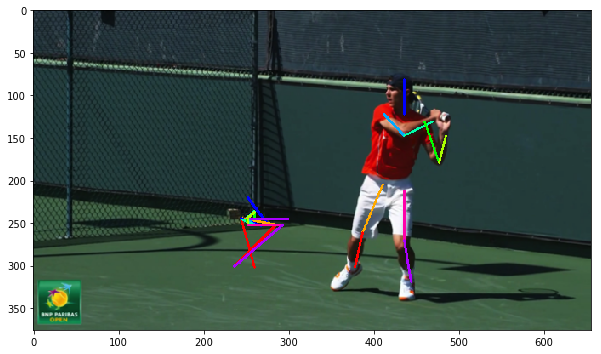

In [7]:
parts = detect_parts_heatmaps(_hmap_pose, centers, [H, W])
draw_limbs(image, parts)
plt.figure(figsize=(10,10))
plt.imshow(image)